# Training a NN for metric on CICY with homog

## Import the required packages/functions

In [1]:
import numpy as np
import gc
import sys
import os
import re
import logging
import pickle
import sys
#sys.path.append("/Users/kit/Documents/Phys_Working/MF metric")
#sys.path.append("/home/f/fraser-talientec/PhysicalYukawas")

logging.basicConfig(stream=sys.stdout)

from cymetric.pointgen.pointgen import PointGenerator
from cymetric.pointgen.nphelper import prepare_dataset, prepare_basis_pickle

import tensorflow as tf
import tensorflow.keras as tfk

tf.get_logger().setLevel('ERROR')


from cymetric.models.tfmodels import PhiFSModel, MultFSModel, FreeModel, MatrixFSModel, AddFSModel, PhiFSModelToric, MatrixFSModelToric
from cymetric.models.tfhelper import prepare_tf_basis, train_model
from cymetric.models.callbacks import SigmaCallback, KaehlerCallback, TransitionCallback, RicciCallback, VolkCallback, AlphaCallback
from cymetric.models.metrics import SigmaLoss, KaehlerLoss, TransitionLoss, RicciLoss, VolkLoss, TotalLoss

from NewCustomMetrics import *
from laplacian_funcs import *
#from generate_and_train_all_nnsHOLO import *
from custom_networks import *
import sys
import importlib
from AlphaPrimeModel import *
#reimport ALphaPrimeModel
importlib.reload(sys.modules['AlphaPrimeModel'])
from AlphaPrimeModel import *
#reimport custom_networks
importlib.reload(sys.modules['custom_networks'])
from custom_networks import *




## Point Cloud Generation

Set the properties of the defining polynomial. And the point in Kahler Moduli space

If correct, this should be for the following defining polynomial
$0.44 x_{1,0}^2 x_{3,0}^2 x_{4,0}^2 x_{2,0}^2+0.88 x_{1,1}^2 x_{3,0}^2 x_{4,0}^2 x_{2,0}^2+0.88 x_{1,0}^2 x_{3,1}^2 x_{4,0}^2 x_{2,0}^2+0.88 x_{1,1}^2 x_{3,1}^2 x_{4,0}^2 x_{2,0}^2-0.03 x_{1,0} x_{1,1} x_{3,0} x_{3,1} x_{4,0}^2 x_{2,0}^2+0.44 x_{1,0}^2 x_{3,0}^2 x_{4,1}^2 x_{2,0}^2+0.44 x_{1,1}^2 x_{3,0}^2 x_{4,1}^2 x_{2,0}^2+0.88 x_{1,0}^2 x_{3,1}^2 x_{4,1}^2 x_{2,0}^2+0.44 x_{1,1}^2 x_{3,1}^2 x_{4,1}^2 x_{2,0}^2-0.41 x_{1,0} x_{1,1} x_{3,0} x_{3,1} x_{4,1}^2 x_{2,0}^2-0.41 x_{1,0} x_{1,1} x_{3,0}^2 x_{4,0} x_{4,1} x_{2,0}^2-0.03 x_{1,0} x_{1,1} x_{3,1}^2 x_{4,0} x_{4,1} x_{2,0}^2+0.62 x_{1,0}^2 x_{3,0} x_{3,1} x_{4,0} x_{4,1} x_{2,0}^2+0.62 x_{1,1}^2 x_{3,0} x_{3,1} x_{4,0} x_{4,1} x_{2,0}^2-0.62 x_{1,0} x_{1,1} x_{2,1} x_{3,0}^2 x_{4,0}^2 x_{2,0}-0.62 x_{1,0} x_{1,1} x_{2,1} x_{3,1}^2 x_{4,0}^2 x_{2,0}+0.41 x_{1,0}^2 x_{2,1} x_{3,0} x_{3,1} x_{4,0}^2 x_{2,0}+0.03 x_{1,1}^2 x_{2,1} x_{3,0} x_{3,1} x_{4,0}^2 x_{2,0}-0.62 x_{1,0} x_{1,1} x_{2,1} x_{3,0}^2 x_{4,1}^2 x_{2,0}-0.62 x_{1,0} x_{1,1} x_{2,1} x_{3,1}^2 x_{4,1}^2 x_{2,0}+0.03 x_{1,0}^2 x_{2,1} x_{3,0} x_{3,1} x_{4,1}^2 x_{2,0}+0.41 x_{1,1}^2 x_{2,1} x_{3,0} x_{3,1} x_{4,1}^2 x_{2,0}+0.41 x_{1,0}^2 x_{2,1} x_{3,0}^2 x_{4,0} x_{4,1} x_{2,0}+0.03 x_{1,1}^2 x_{2,1} x_{3,0}^2 x_{4,0} x_{4,1} x_{2,0}+0.03 x_{1,0}^2 x_{2,1} x_{3,1}^2 x_{4,0} x_{4,1} x_{2,0}+0.41 x_{1,1}^2 x_{2,1} x_{3,1}^2 x_{4,0} x_{4,1} x_{2,0}+0.9 x_{1,0} x_{1,1} x_{2,1} x_{3,0} x_{3,1} x_{4,0} x_{4,1} x_{2,0}+0.44 x_{1,0}^2 x_{2,1}^2 x_{3,0}^2 x_{4,0}^2+0.88 x_{1,1}^2 x_{2,1}^2 x_{3,0}^2 x_{4,0}^2+0.44 x_{1,0}^2 x_{2,1}^2 x_{3,1}^2 x_{4,0}^2+0.44 x_{1,1}^2 x_{2,1}^2 x_{3,1}^2 x_{4,0}^2-0.41 x_{1,0} x_{1,1} x_{2,1}^2 x_{3,0} x_{3,1} x_{4,0}^2+0.88 x_{1,0}^2 x_{2,1}^2 x_{3,0}^2 x_{4,1}^2+0.88 x_{1,1}^2 x_{2,1}^2 x_{3,0}^2 x_{4,1}^2+0.88 x_{1,0}^2 x_{2,1}^2 x_{3,1}^2 x_{4,1}^2+0.44 x_{1,1}^2 x_{2,1}^2 x_{3,1}^2 x_{4,1}^2-0.03 x_{1,0} x_{1,1} x_{2,1}^2 x_{3,0} x_{3,1} x_{4,1}^2-0.03 x_{1,0} x_{1,1} x_{2,1}^2 x_{3,0}^2 x_{4,0} x_{4,1}-0.41 x_{1,0} x_{1,1} x_{2,1}^2 x_{3,1}^2 x_{4,0} x_{4,1}+0.62 x_{1,0}^2 x_{2,1}^2 x_{3,0} x_{3,1} x_{4,0} x_{4,1}+0.62 x_{1,1}^2 x_{2,1}^2 x_{3,0} x_{3,1} x_{4,0} x_{4,1}$

In [2]:
monomialsTQ = 5*np.eye(5, dtype=np.int64)
coefficientsTQ = np.ones(5)
kmoduliTQ = np.ones(1)
ambientTQ = np.array([4])
nameofmanifold="Quintic"




def generate_points_and_save_using_defaults(free_coefficient,number_points,force_generate=False,seed_set=0):
   coefficients=coefficientsTQ
   # coefficients=np.array([1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, \
   # 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, free_coefficient, 0, 0, 0, 0, 0, \
   # 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, \
   # 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1])
   monomials=monomialsTQ
   kmoduli=kmoduliTQ
   ambient=ambientTQ
   # monomials = 5*np.eye(5, dtype=np.int64)
   # coefficients = np.ones(5)
   
   # kmoduli = np.ones(1)
   # ambient = np.array([4])
   pg = PointGenerator(monomials, coefficients, kmoduli, ambient)
   pg._set_seed(seed_set)
   dirname = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   print("dirname: " + dirname)
   #test if the directory exists, if not, create it
   if force_generate or (not os.path.exists(dirname)):
      print("Generating: forced? " + str(force_generate))
      kappa = pg.prepare_dataset(number_points, dirname)
      pg.prepare_basis(dirname, kappa=kappa)
   elif os.path.exists(dirname):
      try:
         print("loading prexisting dataset")
         data = np.load(os.path.join(dirname, 'dataset.npz'))
         if (len(data['X_train'])+len(data['X_val']))!=number_points:
            print("wrong length - generating anyway")
            kappa = pg.prepare_dataset(number_points, dirname)
            pg.prepare_basis(dirname, kappa=kappa)
      except:
         print("error loading - generating anyway")
         kappa = pg.prepare_dataset(number_points, dirname)
         pg.prepare_basis(dirname, kappa=kappa)
   

def getcallbacksandmetrics(data):
   #rcb = RicciCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
   scb = SigmaCallback((data['X_val'], data['y_val']))
   volkcb = VolkCallback((data['X_val'], data['y_val']))
   kcb = KaehlerCallback((data['X_val'], data['y_val']))
   tcb = TransitionCallback((data['X_val'], data['y_val']))
   #cb_list = [rcb, scb, kcb, tcb, volkcb]
   cb_list = [ scb, kcb, tcb, volkcb]
   cmetrics = [TotalLoss(), SigmaLoss(), KaehlerLoss(), TransitionLoss(), VolkLoss()]#, RicciLoss()]
   return cb_list, cmetrics

def train_and_save_nn(free_coefficient,nlayer=3,nHidden=128,nEpochs=50,stddev=0.1,bSizes=[192,50000],lRate=0.001,use_zero_network=False):
   dirname = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   name = 'phimodel_for_' + str(nEpochs) + '_' + str(bSizes[0]) + '_'+ str(bSizes[1]) + 's' + str(nlayer) + 'x' +str(nHidden)
   print('dirname: ' + dirname)
   print('name: ' + name)
   
   data = np.load(os.path.join(dirname, 'dataset.npz'))
   BASIS = prepare_tf_basis(np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True))

   cb_list, cmetrics = getcallbacksandmetrics(data)

   act = 'gelu'
   alpha = [1., 1., 30., 1., 2.] # 1 AND 3??
   ambient=tf.cast(tf.math.abs(BASIS['AMBIENT']),tf.int32)

   #nfirstlayer=tf.reduce_prod(2*(np.array(ambient)+1)).numpy().item()
   nfirstlayer=tf.reduce_prod((np.array(ambient)+1)**2).numpy().item()
   shapeofinternalnetwork=[nHidden]*nlayer
   shapeofnetwork=[nfirstlayer]+shapeofinternalnetwork+[1]

   print("network shape: " + str(shapeofnetwork))
   nn_phi = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_phi=make_nn(10,1,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_phi_zero =BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   # print(nn_phi_zero(tf.cast(data['X_val'][0:2],tf.float32)))
   #nn_phi_zero=make_nn(10,1,nlayer,nHidden,act,use_zero_network=True)
   phimodel = PhiFSModel(nn_phi, BASIS, alpha=alpha)
   phimodelzero = PhiFSModel(nn_phi_zero, BASIS, alpha=alpha)

   #Note, currently running legacy due to ongoing tf issue with M1/M2. 
   #Use the commented line instead if not on an M1/M2 machine
   opt = tfk.optimizers.Adam(learning_rate=lRate)
   #opt = tfk.optimizers.legacy.Adam(learning_rate=lRate)
   # compile so we can test on validation set before training
   phimodel.compile(custom_metrics=cmetrics)
   phimodelzero.compile(custom_metrics=cmetrics)

   ## compare validation loss before training for zero network and nonzero network
   datacasted=[tf.cast(data['X_val'],tf.float32),tf.cast(data['y_val'],tf.float32)]
   #need to re-enable learning, in case there's been a problem:
   phimodel.learn_transition = False
   phimodelzero.learn_transition = False
   phimodel.learn_volk = True
   phimodelzero.learn_volk = True
   #phimodel.learn_ricci_val= True
   #phimodelzero.learn_ricci_val= True
   valzero=phimodelzero.test_step(datacasted)
   valraw=phimodel.test_step(datacasted)
   # phimodel.learn_ricci_val=False 
   # phimodelzero.learn_ricci_val=False 
   valzero = {key: value.numpy() for key, value in valzero.items()}
   valraw = {key: value.numpy() for key, value in valraw.items()}

   phimodel, training_history = train_model(phimodel, data, optimizer=opt, epochs=nEpochs, batch_sizes=bSizes, 
                                       verbose=1, custom_metrics=cmetrics, callbacks=cb_list)
   print("finished training\n")
   phimodel.model.save(os.path.join(dirname, name))
   np.savez_compressed(os.path.join(dirname, 'trainingHistory-' + name),training_history)
   #now print the initial losses and final losses for each metric
   # first_metrics = {key: value[0] for key, value in training_history.items()}
   # lastometrics = {key: value[-1] for key, value in training_history.items()}
   phimodel.learn_transition = True
   phimodel.learn_volk = True
   #phimodel.learn_ricci_val= True
   valfinal=phimodel.test_step(datacasted)
   valfinal = {key: value.numpy() for key, value in valfinal.items()}
   #phimodel.learn_ricci_val=False 
   print("zero network validation loss: ")
   print(valzero)
   print("validation loss for raw network: ")
   print(valraw)
   print("validation loss for final network: ")
   print(valfinal)
   print("ratio of final to zero: " + str({key + " ratio": value/(valzero[key]+1e-8) for key, value in valfinal.items()}))
   print("ratio of final to raw: " + str({key + " ratio": value/(valraw[key]+1e-8) for key, value in valfinal.items()}))

   averagediscrepancyinstdevs,_=compute_transition_pointwise_measure(phimodel,tf.cast(data["X_val"],tf.float32))
   print("average transition discrepancy in standard deviations: " + str(averagediscrepancyinstdevs))
   #IMPLEMENT THE FOLLOWING
   #meanfailuretosolveequation,_,_=measure_laplacian_failure(phimodel,data)
   print("\n\n")
   return phimodel,training_history

def load_nn_phimodel(free_coefficient,nlayer=3,nHidden=128,nEpochs=50,bSizes=[192,50000],stddev=0.1,lRate=0.001,set_weights_to_zero=False):
   dirname = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   name = 'phimodel_for_' + str(nEpochs) + '_' + str(bSizes[0]) + '_'+ str(bSizes[1]) + 's' + str(nlayer) + 'x' +str(nHidden)
   print(dirname)
   print(name)
   
   data = np.load(os.path.join(dirname, 'dataset.npz'))
   BASIS = prepare_tf_basis(np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True))

   cb_list, cmetrics = getcallbacksandmetrics(data)


   act = 'gelu'

   alpha = [1., 1., 30., 1., 2.] # 1 AND 3??
 


   ambient=tf.cast(BASIS['AMBIENT'],tf.int32)

   nfirstlayer=tf.reduce_prod((np.array(ambient)+1)**2).numpy().item()
   shapeofinternalnetwork=[nHidden]*nlayer
   shapeofnetwork=[nfirstlayer]+shapeofinternalnetwork+[1]

   print("network shape: " + str(shapeofnetwork))
   nn_phi = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_phi_zero =BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)


#    nn_phi = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
#    nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
   phimodel = PhiFSModel(nn_phi, BASIS, alpha=alpha)
   phimodelzero = PhiFSModel(nn_phi_zero, BASIS, alpha=alpha)

   if set_weights_to_zero:
      training_history=0
   else:
      phimodel.model=tf.keras.models.load_model(os.path.join(dirname,name))
      training_history=np.load(os.path.join(dirname, 'trainingHistory-' + name +'.npz'),allow_pickle=True)['arr_0'].item()

   phimodel.compile(custom_metrics=cmetrics)
   phimodelzero.compile(custom_metrics=cmetrics)

   # compare validation loss before training for zero network and nonzero network
   datacasted=[tf.cast(data['X_val'],tf.float32),tf.cast(data['y_val'],tf.float32)]
   #need to re-enable learning, in case there's been a problem:
   phimodel.learn_transition = True
   phimodelzero.learn_transition = True
   phimodel.learn_volk = True
   phimodelzero.learn_volk = True
   #phimodel.learn_ricci_val= True
   #phimodelzero.learn_ricci_val= True
   valzero=phimodelzero.evaluate(datacasted[0],datacasted[1],return_dict=True)
   valtrained=phimodel.evaluate(datacasted[0],datacasted[1],return_dict=True)
   #metricsnames=phimodel.metrics_names
   # phimodel.learn_ricci_val=False 
   # phimodelzero.learn_ricci_val=False 
   #valzero = {metricsnames[i]: valzero[i] for i in range(len(valzero))}
   #valtrained= {metricsnames[i]: valtrained[i] for i in range(len(valtrained))}

   #valzero = {key: value.numpy() for key, value in valzero.items()}
   #valtrained = {key: value.numpy() for key, value in valtrained.items()}

   #valtrained = {key: value.numpy() for key, value in valtrained.items()}

   phimodel.learn_transition = True
   phimodel.learn_volk = True

   print("zero network validation loss: ")
   print(valzero)
   print("validation loss for final network: ")
   print(valtrained)
   print("ratio of trained to zero: " + str({key + " ratio": value/(valzero[key]+1e-8) for key, value in valtrained.items()}))
   averagediscrepancyinstdevs,_=compute_transition_pointwise_measure(phimodel,tf.cast(data["X_val"],tf.float32))
   print("average transition discrepancy in standard deviations: " + str(averagediscrepancyinstdevs))
   print("\n\n")
   #IMPLEMENT THE FOLLOWING
   #meanfailuretosolveequation,_,_=measure_laplacian_failure(phimodel,data)
   #print("\n\n")
   #print("mean of difference/mean of absolute value of source, weighted by sqrt(g): " + str(meanfailuretosolveequation))
   return phimodel,training_history

In [3]:

def generate_points_and_save_using_defaultsAlpha(free_coefficient,phimodel,euler_char,force_generate=False,seed_set=0):
   coefficients=coefficientsTQ
   # coefficients=np.array([1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, \
   # 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, free_coefficient, 0, 0, 0, 0, 0, \
   # 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, \
   # 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1])
   monomials=monomialsTQ
   kmoduli=kmoduliTQ
   ambient=ambientTQ
   # monomials = 5*np.eye(5, dtype=np.int64)
   # coefficients = np.ones(5)
   
   # kmoduli = np.ones(1)
   # ambient = np.array([4])
   pg = PointGenerator(monomials, coefficients, kmoduli, ambient)
   pg._set_seed(seed_set)


   dirnameForMetric = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 
   #dirnameAlpha = 'dataAlphaP/tetraquadricAlpha_pg_with_'+str(free_coefficient)+'forLB_'+lbstring
   #dirnameForMetric = 'dataAlphaP/tetraquadric_pg_with_'+str(free_coefficient)
   print("dirname for alpha: " + dirnameForMetric)
   print("dirname for alpha: " + dirnameAlpha)

   BASIS = prepare_tf_basis(np.load(os.path.join(dirnameForMetric, 'basis.pickle'), allow_pickle=True))
   
   data=np.load(os.path.join(dirnameForMetric, 'dataset.npz'))

   if force_generate or (not os.path.exists(dirnameAlpha)):
      print("Generating: forced? " + str(force_generate))
      kappaAlpha = prepare_dataset_Alpha(pg,data,dirnameAlpha,phimodel,euler_char,BASIS,normalize_to_vol_j=True);
   elif os.path.exists(dirnameAlpha):
      try:
         print("loading prexisting dataset")
         data = np.load(os.path.join(dirnameAlpha, 'dataset.npz'))
      except:
         print("problem loading data - generating anyway")
         kappaAlpha = prepare_dataset_Alpha(pg,data, dirnameAlpha,phimodel,euler_char,BASIS,normalize_to_vol_j=True);
      
   

def getcallbacksandmetricsAlpha(dataalpha):
   dataalpha_val_dict=dict(list(dict(dataalpha).items())[len(dict(dataalpha))//2:])
   tcb = TransitionCallback((dataalpha['X_val'], dataalpha['y_val']))
   lplcb = LaplacianCallback(dataalpha_val_dict)
   # lplcb = LaplacianCallback(data_val)
   cb_list = [lplcb,tcb]
   cmetrics = [TotalLoss(), LaplacianLoss(), TransitionLoss()]
   return cb_list, cmetrics

   
def train_and_save_nn_Alpha(free_coefficient,phimodel,euler_char,alphaprime,nlayer=3,nHidden=128,nEpochs=30,bSizes=[192,50000],stddev=0.1,lRate=0.001,alpha=[1,1],load_network=False,use_zero_network=False):
   
   dirnameForMetric = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 

   #data = np.load(os.path.join(dirname, 'dataset.npz'))
   BASIS = prepare_tf_basis(np.load(os.path.join(dirnameForMetric, 'basis.pickle'), allow_pickle=True))


   dataalpha = np.load(os.path.join(dirnameAlpha, 'dataset.npz'))
   dataalpha_train=tf.data.Dataset.from_tensor_slices(dict(list(dict(dataalpha).items())[:len(dict(dataalpha))//2]))
   dataalpha_val_dict=dict(list(dict(dataalpha).items())[len(dict(dataalpha))//2:])
   dataalpha_val=tf.data.Dataset.from_tensor_slices(dataalpha_val_dict)
   # batch_sizes=[64,10000]
   dataalpha_train=dataalpha_train.shuffle(buffer_size=1024).batch(bSizes[0])

   cb_list, cmetrics = getcallbacksandmetricsAlpha(dataalpha)

   #nlayer = 3
   #nHidden = 128
   act = 'gelu'
   #nEpochs = 30
   #bSizes = [192, 150000]
   #alpha = [1., 1.] # 1 AND 3??
   nfold = 3
   n_in = 2*8
   n_out = 1
   #lRate = 0.001
   name = 'alphamodel_for_' + str(nEpochs) + '_' + str(bSizes[0]) + '_'+ str(nlayer) + 'x' +str(nHidden)
   print("name: " + name)

   ambient=tf.cast(BASIS['AMBIENT'],tf.int32)

   nfirstlayer=tf.reduce_prod((np.array(ambient)+1)**2).numpy().item()
   #nfirstlayer=tf.reduce_sum(((np.array(ambient)+1)**2)).numpy().item()
   shapeofinternalnetwork=[nHidden]*nlayer
   shapeofnetwork=[nfirstlayer]+shapeofinternalnetwork+[1]

   print("network shape: " + str(shapeofnetwork))
   #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=stddev)
   #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha_zero = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   activ=tf.square
   #activ=tfk.activations.gelu
   #nn_alpha = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha_zero = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_alpha_zero =BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #copie from phi above
   #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha_zero =BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)

   #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.2)
   #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)#note we don't need a last bias (flat direction)
   #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network,kernel_initializer=initializer)#note we don't need a last bias (flat direction)
   #nn_alpha_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)#note we don't need a last bias (flat direction)
   
   alphamodel= AlphaPrimeModel(nn_alpha,BASIS, phimodel,alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])
   if load_network:
      print("loading network")
      alphamodel.model=tf.keras.models.load_model(os.path.join(dirnameAlpha,name))
      print("network loaded")

   alphamodelzero= AlphaPrimeModel(nn_alpha_zero,BASIS,phimodel, alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])

   #Note, currently running legacy due to ongoing tf issue with M1/M2. 
   #Use the commented line instead if not on an M1/M2 machine
   #opt = tfk.optimizers.Adam(learning_rate=lRate)
   opt = tfk.optimizers.legacy.Adam(learning_rate=lRate)
   # compile so we can test on validation set before training
   alphamodel.compile(custom_metrics=cmetrics)
   alphamodelzero.compile(custom_metrics=cmetrics)
   
   #datacasted=[tf.cast(data['X_val'],tf.float32),tf.cast(data['y_val'],tf.float32)]
   valzero=alphamodelzero.test_step(dataalpha_val_dict)
   valraw=alphamodel.test_step(dataalpha_val_dict)
   valzero = {key: value.numpy() for key, value in valzero.items()}
   valraw = {key: value.numpy() for key, value in valraw.items()}
   
   training_historyAlpha={'transition_loss': [10**(-8)],'laplacian_loss': [1000000000000000]}
   i=0
   newLR=lRate
   #while (training_historyAlpha['transition_loss'][-1]<10**(-5)) or (training_historyAlpha['laplacian_loss'][-1]>1.):
   # continue looping if >10 or is nan
   while i==0:#(training_historyAlpha['laplacian_loss'][-1]>10000000000000.) or (np.isnan( training_historyAlpha['laplacian_loss'][-1])):
      print("trying iteration of training "+str(i))
      if i >0:

         print('trying again laplacian_loss too big')
         #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.2)
         #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network,kernel_initializer=initializer)#note we don't need a last bias (flat direction)
         #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         #nn_alpha = BiholoModelFuncGENERALforAlphainv2(shapeofnetwork,BASIS,activation=tfk.activations.gelu,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         #nn_alpha = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=False)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)#note we don't need a last bias (flat direction)
         if newLR>0.0002:
             newLR=newLR/2
             print("new LR " + str(newLR))
         opt = tfk.optimizers.legacy.Adam(learning_rate=newLR)
         alphamodel= AlphaPrimeModel(nn_alpha,BASIS, phimodel,alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])
         cb_list, cmetrics = getcallbacksandmetricsAlpha(dataalpha)
         alphamodel.compile(custom_metrics=cmetrics)
      alphamodel, training_historyAlpha= train_modelalpha(alphamodel, dataalpha_train, optimizer=opt, epochs=nEpochs, batch_sizes=bSizes, 
                                        verbose=1, custom_metrics=cmetrics, callbacks=cb_list)
      i+=1
   print("finished training\n")
   alphamodel.model.save(os.path.join(dirnameAlpha, name))
   np.savez_compressed(os.path.join(dirnameAlpha, 'trainingHistory-' + name),training_historyAlpha)
   valfinal =alphamodel.test_step(dataalpha_val_dict)
   valfinal = {key: value.numpy() for key, value in valfinal.items()}
   #return training_historyAlpha
   #now print the initial losses and final losses for each metric, by taking the first element of each key in the dictionary
   #first_metrics = {key: value[0] for key, value in training_historyAlpha.items()}
   #last_metrics = {key: value[-1] for key, value in training_historyAlpha.items()}

   #print("initial losses")
   #print(first_metrics)
   #print("final losses")
   #print(last_metrics)


   print("zero network validation loss: ")
   print(valzero)
   print("validation loss for raw network: ")
   print(valraw)
   print("validation loss for final network: ")
   print(valfinal)
   print("ratio of final to zero: " + str({key + " ratio": value/(valzero[key]+1e-8) for key, value in valfinal.items()}))
   print("ratio of final to raw: " + str({key + " ratio": value/(valraw[key]+1e-8) for key, value in valfinal.items()}))


   averagediscrepancyinstdevs,_=compute_transition_pointwise_measure(alphamodel,tf.cast(dataalpha["X_val"],tf.float32))
   print("average transition discrepancy in standard deviations: " + str(averagediscrepancyinstdevs))
   meanfailuretosolveequation,_,_=HYM_measure_val(alphamodel,dataalpha)
   print("mean of difference/mean of absolute value of source, weighted by sqrt(g): " + str(meanfailuretosolveequation))
   print("\n\n")
   tf.keras.backend.clear_session()
   return alphamodel,training_historyAlpha

def load_nn_Alpha(free_coefficient,phimodel,euler_char,alphaprime,nlayer=3,nHidden=128,nEpochs=30,bSizes=[192,50000],stddev=0.1,lRate=0.001,alpha=[1,1],set_weights_to_zero=False):
   dirnameForMetric = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 

   name = 'alphamodel_for_' + str(nEpochs) + '_' + str(bSizes[0]) + '_'+ str(nlayer) + 'x' +str(nHidden)
   print("name: " + name)

   #data = np.load(os.path.join(dirname, 'dataset.npz'))
   BASIS = prepare_tf_basis(np.load(os.path.join(dirnameForMetric, 'basis.pickle'), allow_pickle=True))


   dataalpha = np.load(os.path.join(dirnameAlpha, 'dataset.npz'))
   dataalpha_train=tf.data.Dataset.from_tensor_slices(dict(list(dict(dataalpha).items())[:len(dict(dataalpha))//2]))
   dataalpha_val_dict=dict(list(dict(dataalpha).items())[len(dict(dataalpha))//2:])
   dataalpha_val=tf.data.Dataset.from_tensor_slices(dataalpha_val_dict)
   # batch_sizes=[64,10000]
   dataalpha_train=dataalpha_train.shuffle(buffer_size=1024).batch(bSizes[0])

   cb_list, cmetrics = getcallbacksandmetricsAlpha(dataalpha)

   #nlayer = 3
   #nHidden = 128
   act = 'gelu'
   #nEpochs = 30
   #bSizes = [192, 150000]
   alpha = [1., 1.] # 1 AND 3??
   nfold = 3
   n_in = 2*8
   n_out = 1
   #lRate = 0.001
   ambient=tf.cast(BASIS['AMBIENT'],tf.int32)

   nfirstlayer=tf.reduce_prod((np.array(ambient)+1)**2).numpy().item()
   shapeofinternalnetwork=[nHidden]*nlayer
   shapeofnetwork=[nfirstlayer]+shapeofinternalnetwork+[1]

   print("network shape: " + str(shapeofnetwork))
   #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=stddev)
   #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha_zero = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   activ=tf.square
   nn_alpha = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,stddev=stddev,use_zero_network=set_weights_to_zero)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_alpha_zero = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #copie from phi above
   #nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
   
   #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)#note we don't need a last bias (flat direction)
   #nn_alpha_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)#note we don't need a last bias (flat direction)
   alphamodel= AlphaPrimeModel(nn_alpha,BASIS, phimodel,alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])
   alphamodelzero= AlphaPrimeModel(nn_alpha_zero,BASIS,phimodel, alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])

   alphamodel(dataalpha['X_train'][0:1])
   alphamodelzero(dataalpha['X_train'][0:1])

   if set_weights_to_zero:
      training_historyAlpha=0
   else:
      alphamodel.model=tf.keras.models.load_model(os.path.join(dirnameAlpha,name))
      training_historyAlpha=np.load(os.path.join(dirnameAlpha, 'trainingHistory-' + name +'.npz'),allow_pickle=True)['arr_0'].item()

   alphamodel.compile(custom_metrics=cmetrics)
   alphamodelzero.compile(custom_metrics=cmetrics)
   
   valzero=alphamodelzero.evaluate(dataalpha_val_dict,return_dict=True)
   valtrained=alphamodel.evaluate(dataalpha_val_dict,return_dict=True)
   #valzero = {key: value.numpy() for key, value in valzero.items()}
   #valtrained= {key: value.numpy() for key, value in valtrained.items()}


   #metricsnames=alphamodel.metrics_names

   #valtrained= {metricsnames[i]: valtrained[i] for i in range(len(valtrained))}
   ##valzero = {metricsnames[i]: valzero[i] for i in range(len(valzero))}


   

   print("zero network validation loss: ")
   print(valzero)
   print("validation loss for trained network: ")
   print(valtrained)
   print("ratio of trained to zero: " + str({key + " ratio": value/(valzero[key]+1e-8) for key, value in valtrained.items()}))


   averagediscrepancyinstdevs,_=compute_transition_pointwise_measure(alphamodel,tf.cast(dataalpha["X_val"],tf.float32))
   print("average transition discrepancy in standard deviations: " + str(averagediscrepancyinstdevs))
   meanfailuretosolveequation,_,_=HYM_measure_val(alphamodel,dataalpha)
   print("mean of difference/mean of absolute value of source, weighted by sqrt(g): " + str(meanfailuretosolveequation))
   print("\n\n")
   return alphamodel,training_historyAlpha



Now generate example points with a point generator

Geneate the point cloud for our NN training - note that this will take a few mins


Note that "free_coefficient" is just a label for this particular quintic - for the TQ it was psi. Here, it just lets you have different runs not overwrite each other.


In [4]:


nPoints=100000

free_coefficient = 1.9#float(sys.argv[1])
free_coefficient=2.342351
free_coefficient=2.342343234
#free_coefficient=1.# when the coefficient is 1, ensure that it's 1., not 1 for the sake of the filename
#nEpochsPhi=100
nEpochsPhi=10

depthPhi=3
widthPhi=64#128 4 in the 1.0s


train_phi=False
generate_points_and_save_using_defaults(free_coefficient,nPoints)


dirname: dataAlphaP/Quintic_pg_with_2.342343234
loading prexisting dataset


## Training the NN

Now we can start preperation for training the NN

Begin by loading in the required data

In [5]:

if train_phi:
    phimodel1,training_history=train_and_save_nn(free_coefficient,depthPhi,widthPhi,nEpochsPhi,stddev=0.05,bSizes=[64,50000],lRate=0.001) 
else:
    phimodel1,training_history=load_nn_phimodel(free_coefficient,depthPhi,widthPhi,nEpochsPhi,[64,50000],set_weights_to_zero=False)


dataAlphaP/Quintic_pg_with_2.342343234
phimodel_for_10_64_50000s3x64
network shape: [25, 64, 64, 64, 1]
313/313 [==============================] - 4s 4ms/step - loss: 0.5453 - sigma_loss: 0.0067 - kaehler_loss: 0.0000e+00 - transition_loss: 8.1156e-10 - volk_loss: 0.2693
zero network validation loss: 
{'loss': 0.5023784041404724, 'sigma_loss': 0.502377986907959, 'kaehler_loss': 0.0, 'transition_loss': 0.0, 'volk_loss': 2.811732144891721e-07}
validation loss for final network: 
{'loss': 0.5453054904937744, 'sigma_loss': 0.00666390173137188, 'kaehler_loss': 0.0, 'transition_loss': 8.115599303692989e-10, 'volk_loss': 0.2693207859992981}
ratio of trained to zero: {'loss ratio': 1.0854476927054013, 'sigma_loss ratio': 0.013264716552848506, 'kaehler_loss ratio': 0.0, 'transition_loss ratio': 0.08115599303692989, 'volk_loss ratio': 924950.4164446876}
average transition discrepancy in standard deviations: tf.Tensor(2.3270998e-06, shape=(), dtype=float32)





In [6]:
generate_points_and_save_using_defaultsAlpha(free_coefficient,phimodel1,-200.,force_generate=False,seed_set=0)


dirname for alpha: dataAlphaP/Quintic_pg_with_2.342343234
dirname for alpha: dataAlphaP/QuinticAlpha_pg_with_2.342343234
loading prexisting dataset


In [7]:
alphaprime=1
euler_char=-200
depthAlpha=3
widthAlpha=64
nEpochsAlpha=10


train_alpha=False
if train_alpha:
    AlphaModel1,training_historyAlpha=train_and_save_nn_Alpha(free_coefficient,phimodel1,euler_char,alphaprime,depthAlpha,widthAlpha,nEpochsAlpha,bSizes=[64,50000],stddev=0.05,lRate=0.1,use_zero_network=False,alpha=[1.,1.],load_network=False)
else:
    AlphaModel1,training_historyAlpha=load_nn_Alpha(free_coefficient,phimodel1,euler_char,alphaprime,depthPhi,widthPhi,nEpochsPhi,[64,50000],set_weights_to_zero=True)

name: alphamodel_for_10_64_3x64
network shape: [25, 64, 64, 64, 1]
313/313 [==============================] - 3s 3ms/step - loss: 176.0668 - laplacian_loss: 176.0668 - transition_loss: 0.0000e+00
zero network validation loss: 
{'loss': 125.77696228027344, 'laplacian_loss': 125.77696228027344, 'transition_loss': 0.0}
validation loss for trained network: 
{'loss': 125.77696228027344, 'laplacian_loss': 125.77696228027344, 'transition_loss': 0.0}
ratio of trained to zero: {'loss ratio': 0.9999999999204943, 'laplacian_loss ratio': 0.9999999999204943, 'transition_loss ratio': 0.0}
average transition discrepancy in standard deviations: tf.Tensor(nan, shape=(), dtype=float32)
mean of difference/mean of absolute value of source, weighted by sqrt(g): tf.Tensor(1.0, shape=(), dtype=float32)





In [8]:
data=np.load('dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) + '/dataset.npz')
AlphaModel1.model(data['X_train'][0:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

In [9]:
#reimport custom_networks
importlib.reload(sys.modules['custom_networks'])
from custom_networks import *
#reimport laplacian_funcs
importlib.reload(sys.modules['laplacian_funcs'])
from laplacian_funcs import *

In [10]:
#(self,kphi,linebundleindices,ambient_env_var,n_projective,kmoduli)
n_0=0
n_p= 100000
ptdata=tf.cast(data['X_train'],tf.float32)[n_0:n_p]
#cptdata=point_vec_to_complex(ptdata)
#cptdata2=cptdata/cptdata[:,0:1]
flat_measure_weights=((data['y_train'][:,0]/(data['y_train'][:,1]))*(1/(6)))[n_0:n_p]
pullbacks=AlphaModel1.pullbacks(ptdata)#[n_0:n_p]
kphi = np.array([3])
#get_sections_cpts_func=get_degree_kphiandMmonomials_general(kphi,[0],ambientTQ,len(ambientTQ),kmoduliTQ)
# get_sections_cpts_func(cptdata)


In [11]:

#tf.function this, but for fixed arguments 0,2 and tensor arguments 1,3,4

def compute_matrices_for_pts(rpoints,metric,flat_measure_weights,pullbacks,get_sections_cpts_func):
    get_sections_rpts_func= lambda x: get_sections_cpts_func(point_vec_to_complex(x))
    metrics = metric(rpoints)
    inversemetrics=tf.linalg.inv(metrics)
    dets = tf.linalg.det(metrics)
    #k_phi=get_sections_rpts_func(cpoints)
    djsigma=extder_j_for_sigma(rpoints,get_sections_rpts_func)
    djbarsigma=extder_jbar_for_sigma(rpoints,get_sections_rpts_func)
    dasigma = tf.einsum('xai,xCi->xCa',pullbacks,djsigma)
    dbbarsigma = tf.einsum('xbj,xCj->xCb',tf.math.conj(pullbacks),djbarsigma)
    #b is barred, a is unbarred
    dbarfbar_df = tf.einsum('xba,xCb,xDa->xCD',inversemetrics,tf.math.conj(dasigma),dasigma)
    dfbar_dbarf = tf.einsum('xba,xCa,xDb->xCD',inversemetrics,tf.math.conj(dbbarsigma),dbbarsigma)
    #factor of 2 form the laplacian!
    integrand_CD = tf.einsum('xCD,x->xCD',2*(dbarfbar_df + dfbar_dbarf),dets*tf.cast(flat_measure_weights,tf.complex64))
    integrand_mean=tf.reduce_mean(integrand_CD,axis=0)
    print("vol: " + str(tf.reduce_mean(dets*tf.cast(flat_measure_weights,tf.complex64))))
    return integrand_mean
#now compute the matrix ele
#kphi = np.array([3])
get_sections_cpts_func=get_degree_kphiandMmonomials_general(kphi,kphi*0,ambientTQ,len(ambientTQ),kmoduliTQ)
#mats=compute_matrices_for_pts(kphi,ptdata,AlphaModel1,flat_measure_weights,pullbacks,get_sections_cpts_func)



In [30]:
def compute_normalising_matrices_for_pts(rpoints,metric,flat_measure_weights,get_sections_cpts_func):
    get_sections_rpts_func= lambda x: get_sections_cpts_func(point_vec_to_complex(x))
    metrics = metric(rpoints)
    dets = tf.linalg.det(metrics)
    sectionsB    = get_sections_rpts_func(rpoints)
    sectionsConjA   = tf.math.conj(sectionsB)

    #k_phi=get_sections_rpts_func(cpoints)
    integrand_CD = tf.einsum('xA,xB,x->AB',sectionsConjA,sectionsB,dets*tf.cast(flat_measure_weights,tf.complex64))/tf.cast(tf.shape(flat_measure_weights)[-1],tf.complex64)
    print("vol: " + str(tf.reduce_mean(dets*tf.cast(flat_measure_weights,tf.complex64))))
    return integrand_CD

In [31]:
@tf.function
def compute_matrices_for_pts_fixed(rpoints, flat_measure_weights, pullbacks):
    #kphi = tf.constant([1])  # Fixed argument
    kphi=np.array([3])
    return compute_matrices_for_pts(rpoints, AlphaModel1, flat_measure_weights, pullbacks,get_sections_cpts_func)

# Get the concrete function
concrete_func = compute_matrices_for_pts_fixed.get_concrete_function(
    tf.TensorSpec(shape=(None,2*AlphaModel1.ncoords), dtype=tf.float32),  # rpoints
    tf.TensorSpec(shape=(None), dtype=tf.float32),  # flat_measure_weights
    tf.TensorSpec(shape=(None, 3,AlphaModel1.ncoords), dtype=tf.complex64)  # pullbacks
)

@tf.function
def compute_normalising_matrices_for_pts_fixed(rpoints, flat_measure_weights):
    #kphi = tf.constant([1])  # Fixed argument
    kphi=np.array([3])
    return compute_normalising_matrices_for_pts(rpoints, AlphaModel1, flat_measure_weights,get_sections_cpts_func)

# Get the concrete function
concrete_func_normalising = compute_normalising_matrices_for_pts_fixed.get_concrete_function(
    tf.TensorSpec(shape=(None,2*AlphaModel1.ncoords), dtype=tf.float32),  # rpoints
    tf.TensorSpec(shape=(None), dtype=tf.float32),  # flat_measure_weights
)

#compute_matrices_for_pts_fixed(ptdata, flat_measure_weights, pullbacks)

vol: Tensor("Mean_1:0", shape=(), dtype=complex64)
vol: Tensor("Mean:0", shape=(), dtype=complex64)


In [24]:
# Assuming the concrete_func is defined as in the previous example

# Create a dataset from your large number of points
dataset = tf.data.Dataset.from_tensor_slices((ptdata, flat_measure_weights, pullbacks))


num_points = 100000
batch_size = 200  # Adjust based on your memory constraints and performance needs


# Batch the dataset
batched_dataset = dataset.batch(batch_size)

# Process batches
results = []
for batch in batched_dataset:
    batch_rpoints, batch_flat_measure_weights, batch_pullbacks = batch
    batch_result = compute_matrices_for_pts_fixed(batch_rpoints, batch_flat_measure_weights, batch_pullbacks)
    results.append(batch_result)


# Combine results if needed
matrix_laplacian_requires_mean = np.array(results)

print(f"Processed {num_points} points. Shape of final result: {final_result.shape}")

results_norm = []
for batch in batched_dataset:
    batch_rpoints, batch_flat_measure_weights,_ = batch
    batch_result_norm = compute_normalising_matrices_for_pts_fixed(batch_rpoints, batch_flat_measure_weights)
    results_norm.append(batch_result_norm)

matrix_normalising_requires_mean = np.array(results_norm)

print(f"Processed {num_points} points. Shape of final result: {final_result_norm.shape}")

vol: Tensor("Mean_1:0", shape=(), dtype=complex64)
Processed 100000 points. Shape of final result: (1225, 1225)


In [170]:
import scipy
#take eigs of final_result


#log distribute over 1 to 100000
number_approx=6

numbers_to_take= np.unique((batch_size*np.round(np.logspace(np.log10(10000),np.log10(len(ptdata)),number_approx)/batch_size)).astype('int'))[0:]
indices_to_take=tf.cast(numbers_to_take/batch_size,tf.int32).numpy()
indices_to_take[0]
print(numbers_to_take)

eigvals_all=[]
for i in indices_to_take:
    matrix=tf.reduce_mean(np.array(results)[0:i],axis=0)
    matrix_norm=tf.reduce_mean(np.array(results_norm)[0:i],axis=0)
    eigvals=tf.math.real(scipy.linalg.eigvals(matrix,matrix_norm))
    eigvals_all.append(np.sort(eigvals))
    #round and print to 2dp
    #eigvals_rounded=np.round(eigvals,2)
    #print(tf.math.real(eigvals_rounded))
eigvals_all=np.array(eigvals_all)

[10000 15600 24000 37400 58000 90000]


In [196]:
((numbers_to_take[-1]-numbers_to_take[0])//5000)

16

(0.0, 300.0)

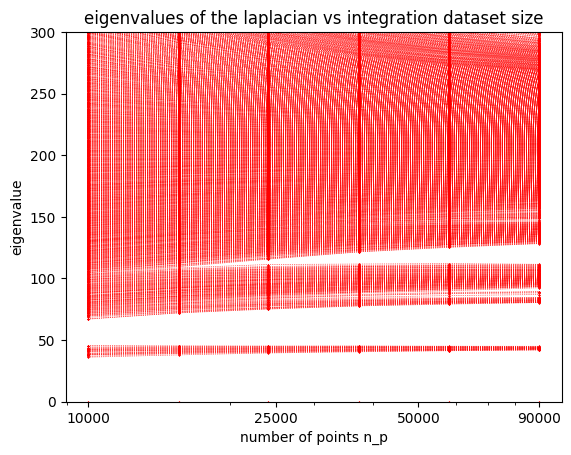

In [206]:
import matplotlib.pyplot as plt
#sort_eigvals_rounded=np.sort(eigvals_rounded)[0:200]
#plt.scatter(range(len(sort_eigvals_rounded)),sort_eigvals_rounded)
numbers_for_plotting=tf.repeat(tf.expand_dims(numbers_to_take,axis=-1),tf.shape(eigvals_all)[-1],axis=-1)
#join each eigval as hte number of points increase with a dotted line
#change the plot to a line plot
#change all the line colours to red and thin, with a small red x at each point
plt.plot(numbers_for_plotting,eigvals_all,marker='x',linestyle='dotted',color='red',linewidth=0.5,markersize=1)
#change the x axis to log scale, labelled at the endpoints with one point in the middle
plt.xscale('log')
middle_pt=((numbers_to_take[-1]-numbers_to_take[0])//(5000*2))*5000 + numbers_to_take[0]
middle_pt2=((numbers_to_take[-1]-numbers_to_take[0])//(5000*5))*5000 + numbers_to_take[0]
ticks = tf.cast(np.concatenate((numbers_to_take[[0,-1]],np.array([middle_pt,middle_pt2])),axis=0),tf.int32).numpy()
plt.xticks(ticks,ticks)
#label the x axis as number of points n_p
#label the y axis as eigenvalue
plt.xlabel('number of points n_p')
plt.ylabel('eigenvalue')
#title the plot as eigenvalues of the laplacian as number of points increases
plt.title('eigenvalues of the laplacian vs integration dataset size')
plt.ylim(0,300)



In [192]:
ticks

array([10000, 90000, 90000, 90000], dtype=int32)